In [32]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

In [12]:
import pandas_datareader.data as web
from __future__ import division
from datetime import datetime

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style = 'whitegrid'
% matplotlib inline

In [89]:
tech_list = ['AAPL', 'MSFT', 'GOOG', 'IBM', 'AMZN']

end = datetime.now()
start = datetime(end.year-1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = web.DataReader(stock, 'quandl', start, end)

In [20]:
AAPL.head()

,Open,High,Low,Close,Volume,ExDividend,SplitRatio,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjVolume
Date,,,,,,,,,,,,
2018-03-27,173.68,175.15,166.92,168.340,38962839.0,0.0,1.0,173.68,175.15,166.92,168.340,38962839.0
2018-03-26,168.07,173.10,166.44,172.770,36272617.0,0.0,1.0,168.07,173.10,166.44,172.770,36272617.0
2018-03-23,168.39,169.92,164.94,164.940,40248954.0,0.0,1.0,168.39,169.92,164.94,164.940,40248954.0
2018-03-22,170.00,172.68,168.60,168.845,41051076.0,0.0,1.0,170.00,172.68,168.60,168.845,41051076.0
2018-03-21,175.04,175.09,171.26,171.270,35247358.0,0.0,1.0,175.04,175.09,171.26,171.270,35247358.0


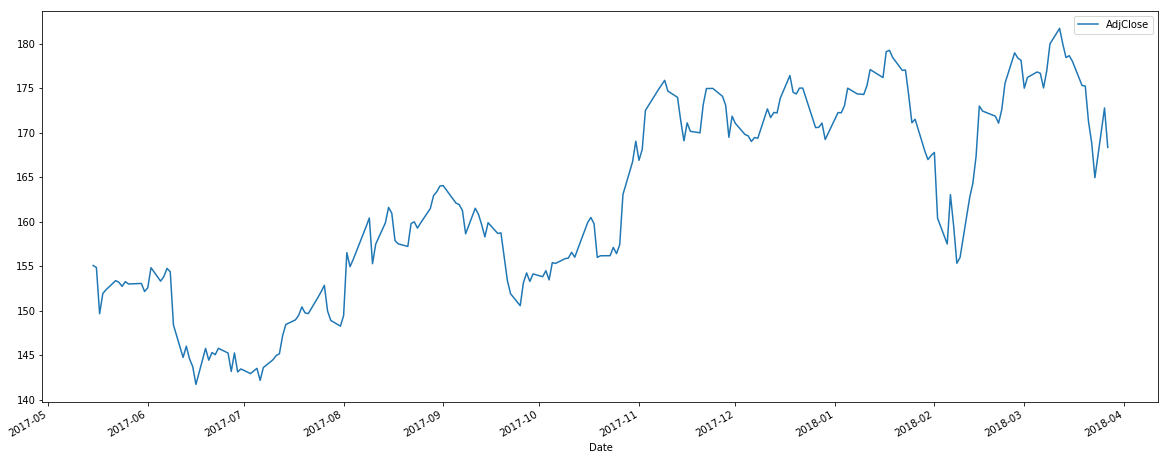

In [25]:
AAPL['AdjClose'].plot(legend=True, figsize=(20,8))

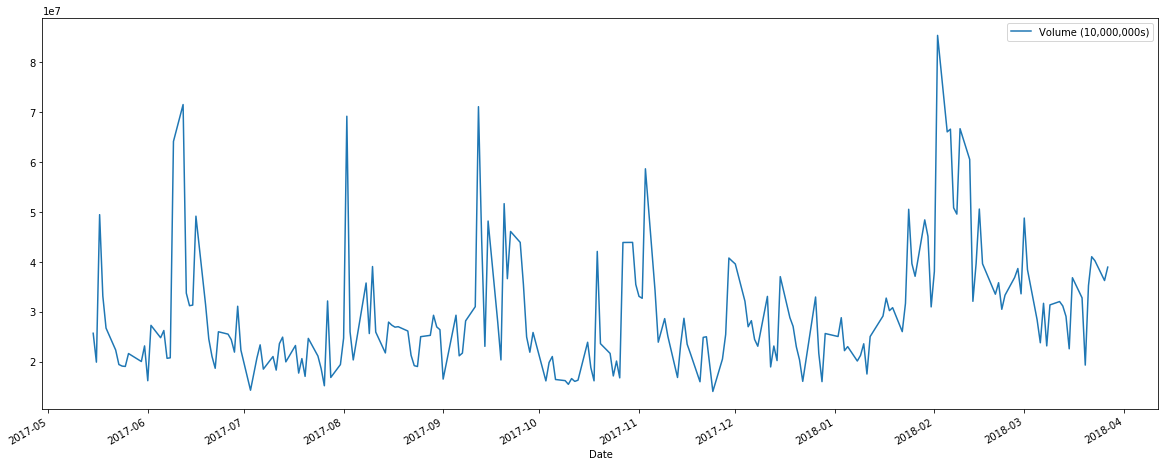

In [29]:
AAPL['Volume'].plot(legend=True, figsize=(20,8), label='Volume (10,000,000s)')


C:\Users\lewis\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  
C:\Users\lewis\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  
C:\Users\lewis\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()
  


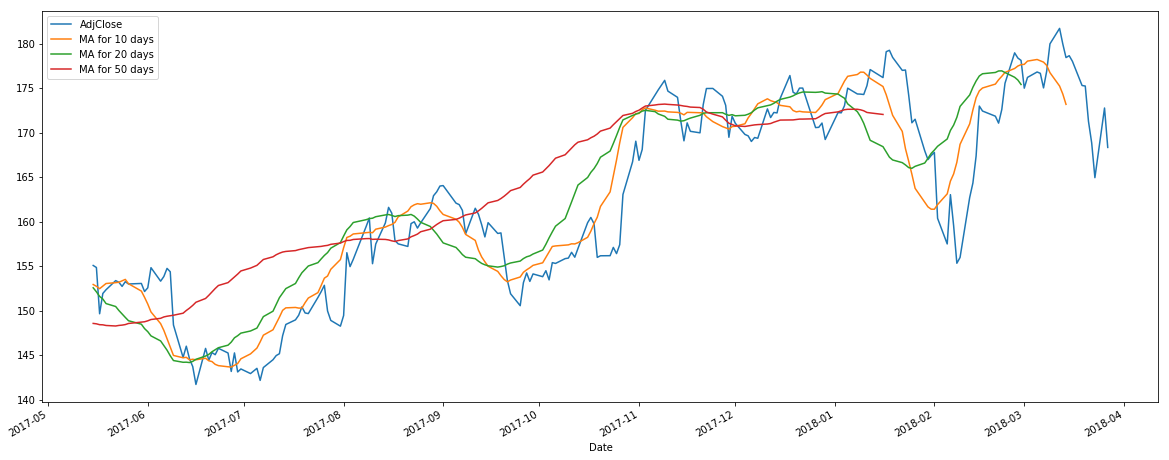

In [36]:
ma_days =[10,20,50]

for ma in ma_days:
    
    column_name = 'MA for %s days' %(str(ma))
    AAPL[column_name] = pd.rolling_mean(AAPL['AdjClose'], ma)
    
AAPL[['AdjClose', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(subplots=False, figsize=(20,8))

In [40]:
AAPL = AAPL.sort_index(ascending=True)

In [42]:
AAPL['ROI'] = AAPL['AdjClose'].pct_change()

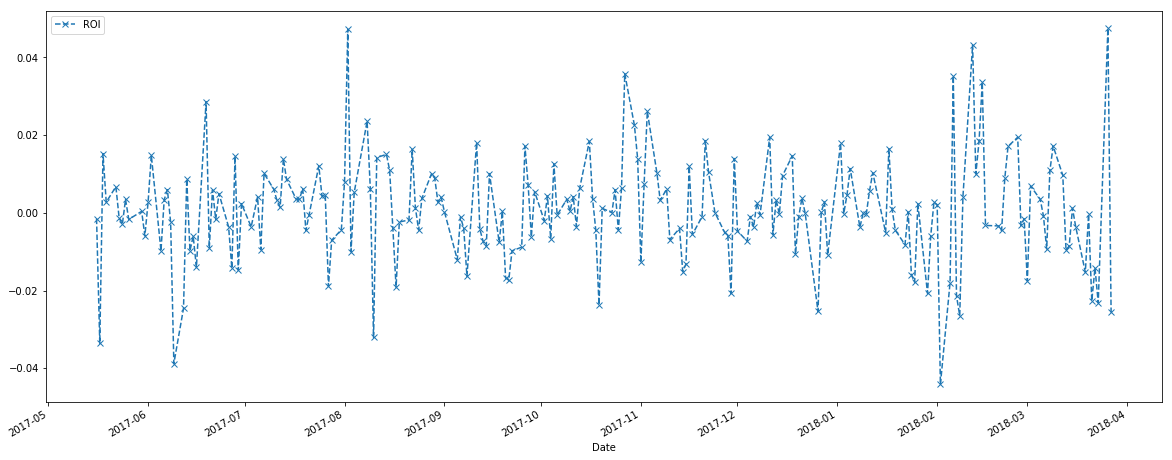

In [47]:
AAPL['ROI'].plot(legend=True, figsize=(20,8), linestyle='--', marker='x')

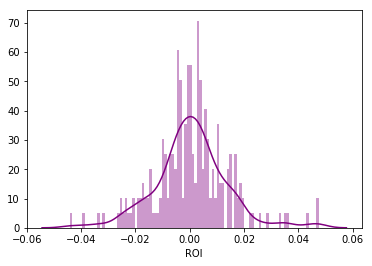

In [49]:
sns.distplot(AAPL['ROI'].dropna(), bins=100, color='Purple')

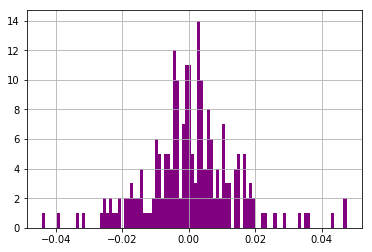

In [50]:
AAPL['ROI'].hist(bins=100, color='purple')

In [90]:
tech_comps_closing = web.DataReader(tech_list, 'robinhood', start, end)['close_price']

In [91]:
tech_comps_closing = tech_comps_closing.unstack(level=0)

In [92]:
tech_comps_closing = tech_comps_closing.astype(float)

In [93]:
roi_tech_comps = tech_comps_closing.pct_change()

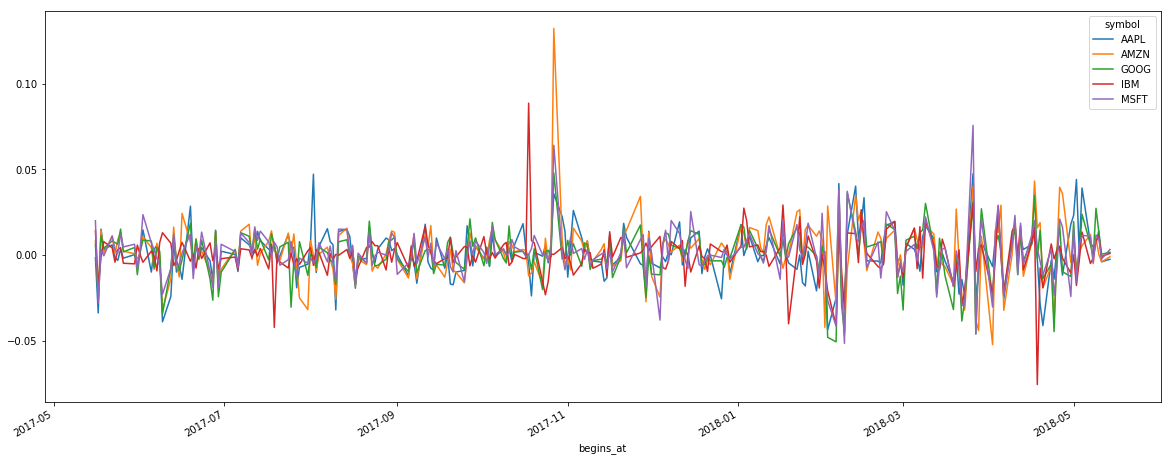

In [94]:
roi_tech_comps.plot(legend=True, subplots=False, figsize=(20,8))

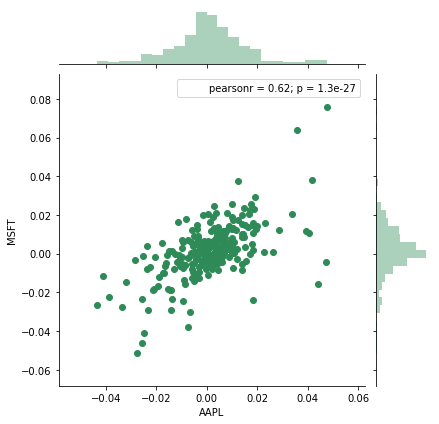

In [97]:
sns.jointplot('AAPL', 'MSFT', roi_tech_comps, kind='scatter', color='seagreen' )

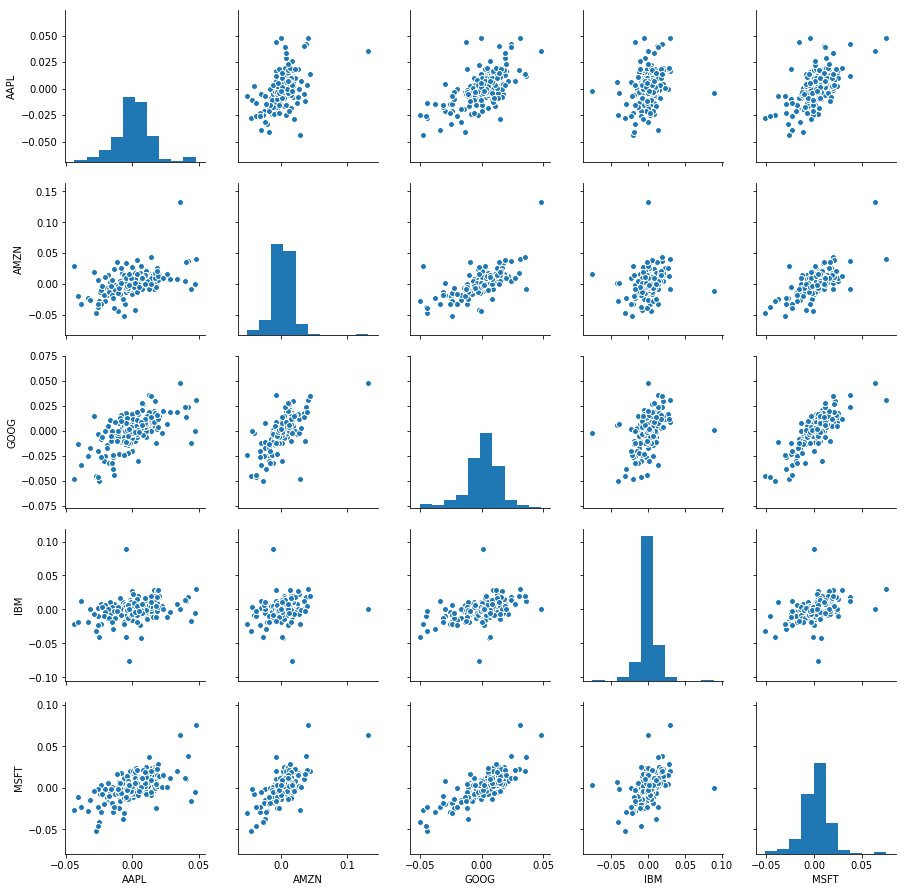

In [98]:
sns.pairplot(roi_tech_comps.dropna())

C:\Users\lewis\Miniconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


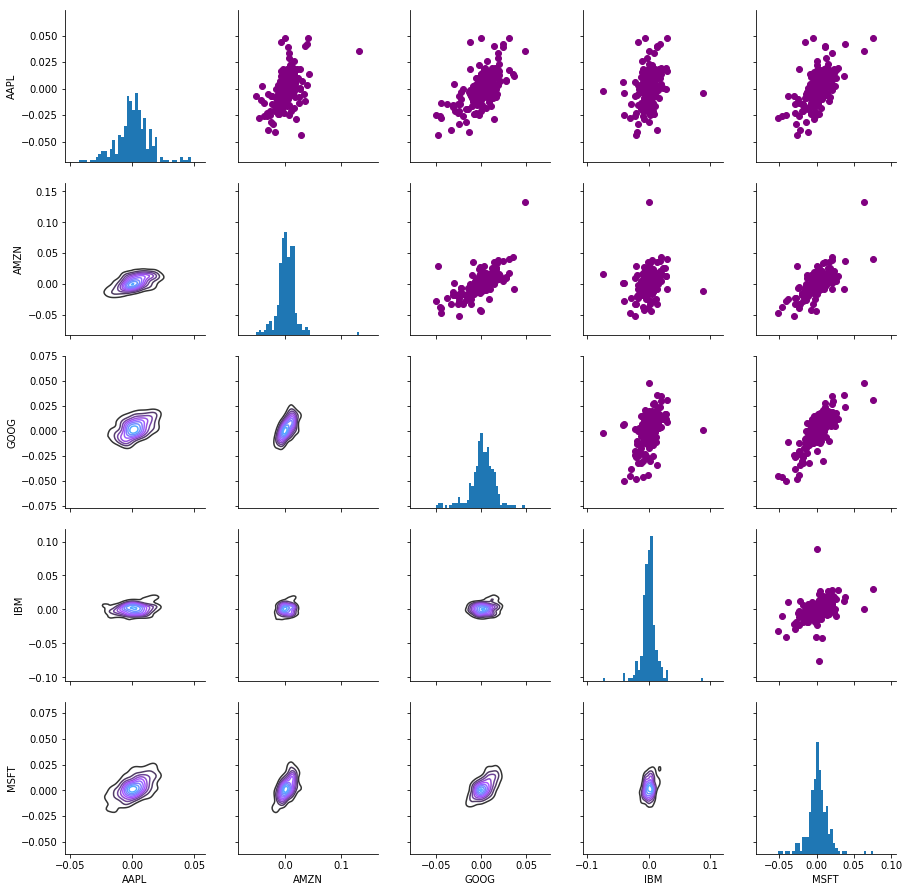

In [103]:
tech_rets_fig = sns.PairGrid(roi_tech_comps.dropna())
tech_rets_fig.map_upper(plt.scatter, marker='o', color='purple')
tech_rets_fig.map_diag(plt.hist, bins=40)
tech_rets_fig.map_lower(sns.kdeplot, cmap='cool_d')

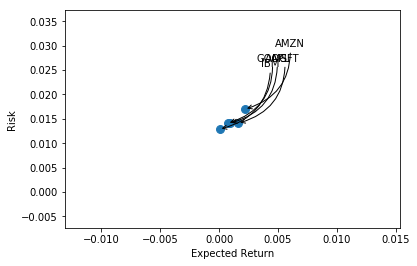

In [132]:
rets = roi_tech_comps.dropna()

area = np.pi*20

plt.scatter(rets.mean(), rets.std(), s=area)

plt.xlabel('Expected Return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(
    label,
    xy=(x,y), xytext=(60, 60),
    textcoords='offset points', ha='right', va='bottom',
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.4'))

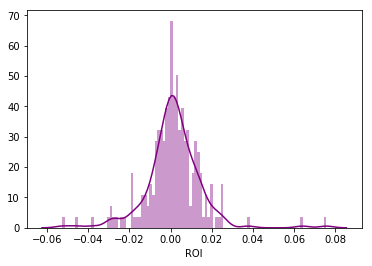

In [150]:
MSFT = MSFT.sort_index(ascending=True)
MSFT['ROI'] = MSFT['AdjClose'].pct_change()
sns.distplot(MSFT['ROI'].dropna(), bins=100, color='purple')

In [152]:
roi_tech_comps['MSFT'].quantile(0.05)

-0.023025816808746557

In [155]:
days = 365
dt = 1/days
mu = roi_tech_comps.mean()['MSFT']
sigma = roi_tech_comps.std()['MSFT']

In [166]:
def monte_carlo_sim(start_price, days, mu, sigma):
    
    price = np.zeros(days)
    price[0] = start_price
    
    drift = np.zeros(days)
    shock = np.zeros(days)
    
    for x in range(1,days):
        drift[x] = mu * dt
        shock[x] = np.random.normal(loc=mu*dt, scale=sigma * np.sqrt(dt))
        price[x] = price[x-1] + (price[x-1] * (drift[x] + shock[x]))

    return price

Text(0.5,1,'Monte Carlo Analysis for Microsoft')

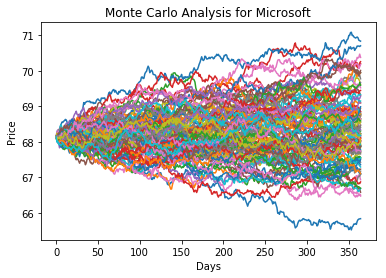

In [170]:
start_price = 68.14
for run in range(100):
    plt.plot(monte_carlo_sim(start_price, days, mu, sigma))
plt.ylabel('Price')
plt.xlabel('Days')
plt.title('Monte Carlo Analysis for Microsoft')

In [172]:
runs = 10000

simulations = np.zeros(runs)

np.set_printoptions(threshold=5)

for run in range(runs):
    simulations[run] = monte_carlo_sim(start_price, days, mu, sigma)[days-1]

Text(0.5,1,'Final price distribution for Microsoft stock after 365 days')

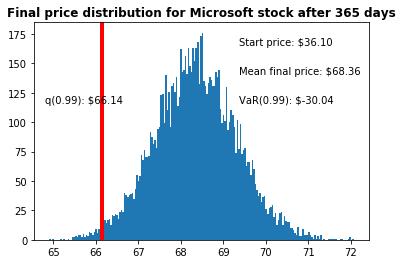

In [234]:
q = np.percentile(simulations, 1)

plt.hist(simulations, bins=200)

plt.figtext(0.6, 0.8, s='Start price: ${:.2f}'.format(start_price)) 
plt.figtext(0.6, 0.7, s='Mean final price: ${:.2f}'.format(simulations.mean()))
plt.figtext(0.6, 0.6, s='VaR(0.99): ${:.2f}'.format((start_price - q)))
plt.figtext(0.15, 0.6, s='q(0.99): ${:.2f}'.format(q))

plt.axvline(x=q, linewidth=4, color='r')

plt.title(u'Final price distribution for Microsoft stock after {} days'.format(days), weight='bold')

In [186]:
oil_companies = ['BP','VLO', 'CVX']
for stock in oil_companies:
    globals()[stock] = web.DataReader(stock, 'quandl', start, end)

In [189]:
BP = BP.sort_index(ascending=True)

In [190]:
BP['ROI'] = BP['AdjClose'].pct_change()

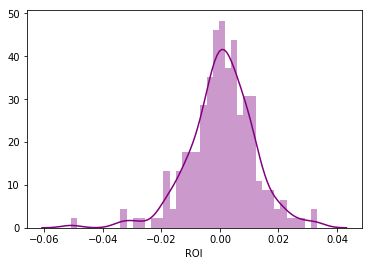

In [194]:
sns.distplot(BP['ROI'].dropna(), bins=40, color='purple')

In [199]:
oil_companies_close = web.DataReader(oil_companies, 'robinhood', start, end)['close_price']

In [201]:
oil_companies_close = oil_companies_close.unstack(level=0)

In [203]:
oil_companies_close = oil_companies_close.astype(float)

In [224]:
roi_oil_companies = oil_companies_close.pct_change()

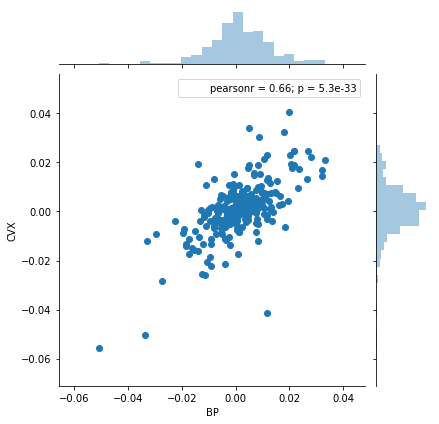

In [207]:
sns.jointplot('BP','CVX', data=roi_oil_companies)

In [208]:
roi_oil_companies['BP'].quantile(0.05)

-0.01593753725546867

In [227]:
roi_oil_companies = roi_oil_companies.dropna()
days = days
dt = 1/days
mu_bp = roi_oil_companies.mean()['BP']
sigma_bp = roi_oil_companies.std()['BP']

In [230]:
def monte_carlo_attempt(start_price, days, mu, sigma):
    price=np.zeros(days)
    price[0]=start_price
    
    shock=np.zeros(days)
    drift=np.zeros(days)
    
    for x in range(1, days):
        drift[x] = mu * dt
        shock[x] = np.random.normal(loc = mu*dt, scale = sigma*np.sqrt(dt))
        price[x] = price[x-1] + (price[x-1] * (drift[x] + shock[x]))
        
    return price

Text(0.5,1,'Monte Carlo simulator for price changes in BP stock')

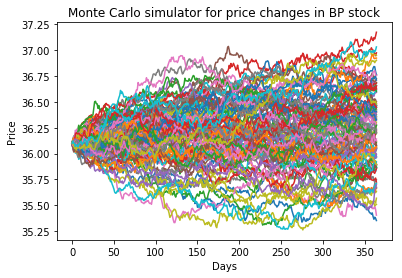

In [231]:
start_price_bp = 36.10

for run in range(100):
    plt.plot(monte_carlo_attempt(start_price_bp, days, mu_bp, sigma_bp))
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Monte Carlo simulator for price changes in BP stock')

In [232]:
runs = 20000

simulation = np.zeros(runs)

np.set_printoptions(threshold=5)

for run in range(runs):
    simulation[run]= monte_carlo_attempt(start_price_bp, days, mu_bp, sigma_bp)[days-1]


Text(0.5,1,'Final Price distribution for BP stock after 365 days')

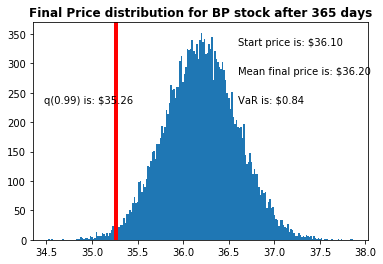

In [235]:
q = np.percentile(simulation, 1)

plt.hist(simulation, bins=200)

plt.figtext(0.6, 0.8, s='Start price is: ${:.2f}'.format(start_price_bp))
plt.figtext(0.6, 0.7, s='Mean final price is: ${:.2f}'.format(simulation.mean()))
plt.figtext(0.6, 0.6, s='VaR is: ${:.2f}'.format((start_price - q)))
plt.figtext(0.15, 0.6, s='q(0.99) is: ${:.2f}'.format(q))

plt.axvline(x=q, linewidth=4, color='r')

plt.title(u'Final Price distribution for BP stock after {} days'.format(days), weight='bold')

In [236]:
portfolio = BP + AAPL + MSFT + CVX

In [238]:
portfolio['ROI'] = portfolio['AdjClose'].pct_change()

In [239]:
portfolio.head()

,AdjClose,AdjHigh,AdjLow,AdjOpen,AdjVolume,Close,ExDividend,High,Low,Open,ROI,SplitRatio,Volume
Date,,,,,,,,,,,,,
2017-05-15,362.249680,364.471437,360.525419,362.950672,71428660.0,366.69,0.00,368.94,364.945,367.40,NaN,4.0,71428660.0
2017-05-16,364.282287,365.537461,361.940328,363.896114,67909767.0,368.37,0.39,369.64,366.005,367.98,0.005611,4.0,67909767.0
2017-05-17,355.663977,363.547149,354.997475,361.522581,95385696.0,358.60,1.08,366.54,357.930,364.50,-0.023658,4.0,95385696.0
2017-05-18,358.972145,360.876403,355.283665,356.580076,74330204.0,361.93,0.00,363.85,358.210,359.52,0.009301,4.0,74330204.0
2017-05-19,361.130183,362.699377,359.099487,360.390128,68118434.0,364.11,0.00,365.69,362.060,363.36,0.006012,4.0,68118434.0


Text(50,50,'Portfolio (ExRet= 0.00, ExRsk= 0.01)')

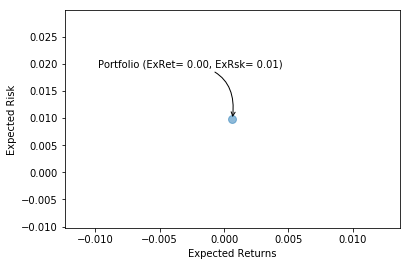

In [258]:
rets_portfolio = portfolio['ROI'].dropna()

area=np.pi*20

plt.scatter(rets_portfolio.mean(), rets_portfolio.std(), alpha=0.5, s=area)

plt.xlabel('Expected Returns')
plt.ylabel('Expected Risk')

plt.annotate(
'Portfolio (ExRet= {:.2f}, ExRsk= {:.2f})'.format(rets_portfolio.mean(), rets_portfolio.std()),
xy=(rets_portfolio.mean(), rets_portfolio.std()), xytext=(50,50),
textcoords='offset points', ha='right', va='bottom',
arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5'))